In [1]:
%matplotlib inline 


import numpy as np #To use functions or constants that are in the NumPy module, type np.function_name. EG: np.pi is pi
import numpy.random as nprd #This imports random number generation functions
import scipy as sp #SciPy has lots of useful numerical methods, so we don't have to write them
import scipy.linalg as spla #This imports the sub-module containing linear algebra methods
import matplotlib.pyplot as plt #This will let us display images nicely
import cv2
import random

In [2]:
# plate size, mm
w = h = 10.
# intervals in x-, y- directions, mm
dx = dy = 0.1
# Thermal diffusivity 
rhoxc=1041*3430
gamma= 0.6923*3430
k=(1/2)*(10**4)
Q_low,Q_high=4,10
D=k/rhoxc
Perfusion=gamma/rhoxc
Tcool = 37

nx, ny = int(w/dx), int(h/dy)

dx2, dy2 = dx*dx, dy*dy

dt=1

u0 = Tcool * np.ones((nx, ny))
u = np.empty((nx, ny))

r, cx, cy = 2, 5, 5

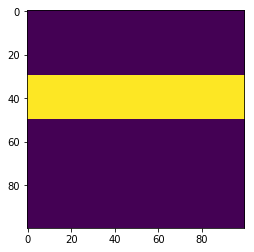

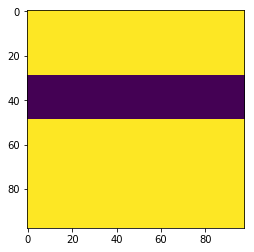

In [3]:
material= np.zeros((nx,ny))
material[3*int(nx/w):int(5*ny/h)]=material[3*int(nx/w):int(5*ny/h)]+1

rhoxc_bone=1420*1700
gamma_bone= 0.892*1700
k_bone=0.38*(10**4)
D_bone=k_bone/rhoxc_bone

Perfusion_bone=gamma_bone/rhoxc_bone


D_matrix=np.empty((nx,ny))
D_matrix[material==0]=D
D_matrix[material==1]=D/4 #D_bone
D_matrix=D_matrix[1:-1, 1:-1]

Perfusion_matrix=np.empty((nx,ny))
Perfusion_matrix[material==0]=Perfusion
Perfusion_matrix[material==1]=Perfusion_bone
Perfusion_matrix=Perfusion_matrix[1:-1, 1:-1]

plt.imshow(material)
plt.show()

plt.imshow(D_matrix)
plt.show()

In [4]:
#Heating at each time step 
def random_heat_source(nx,ny, r, cx, cy, Q_high, Q_low):
    Q = np.zeros((nx, ny))
    r2 = r**2
    for i in range(nx):
        for j in range(ny):
            p2 = (i*dx-cx)**2 + (j*dy-cy)**2
            T=random.uniform(Q_low,Q_high)
            if 0.1<p2 < r2:
                Q[i,j] = T*np.exp(-20*(p2-0.1))
            elif p2<0.1:
                    Q[i,j] = T
    return(Q[1:-1, 1:-1])
Q=random_heat_source(nx,ny, r, cx, cy, Q_high, Q_low)/100


In [5]:
def do_timestep(u0, u):
    # Propagate with forward-difference in time, central-difference in space
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + dt*(np.multiply(D_matrix,
         ( (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
          + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 ))+Q -np.multiply(Perfusion_matrix, (u0[1:-1, 1:-1]-37)))
     
    u0 = u.copy()
    return u0, u

In [6]:
#Do timesteps for thermal dose 
thermal_dose=np.zeros((nx,ny))
def integrate_thermal_dose(u,dt):
    thermal_dose=np.zeros(np.shape(u))
    thermal_dose[u>43]=dt*(0.5**(43-u[u>43]))
    thermal_dose[u<=43]=dt*(0.5**(43-u[u<=43]))
    return(thermal_dose)
            
            


1 1
1000 2
2000 3
3000 4


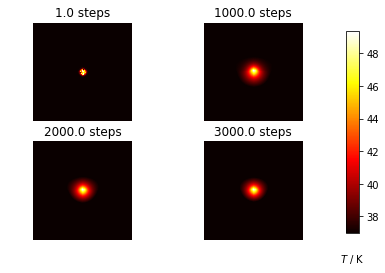

In [7]:
#Do timesteps for temperature

# Number of timesteps
nsteps = 3001
# Output 4 figures at these timesteps
mfig = [1, 1000,2000, 3000]
fignum = 0
fig = plt.figure()
for m in range(nsteps):
    u0, u = do_timestep(u0, u)
    if m in mfig:
        fignum += 1
        print(m, fignum)
        ax = fig.add_subplot(220 + fignum)
        im = ax.imshow(u.copy(), cmap=plt.get_cmap('hot'), vmin=Tcool)
        ax.set_axis_off()
        ax.set_title('{:.1f} steps'.format(m*dt))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('$T$ / K', labelpad=20)
fig.colorbar(im, cax=cbar_ax)
plt.show()

1 1
100 2
200 3
300 4


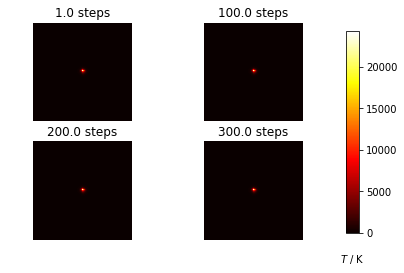

In [8]:


# Number of timesteps
nsteps = 301
# Output 4 figures at these timesteps
mfig = [1, 100,200, 300]
fignum = 0
fig = plt.figure()
for m in range(nsteps):
    u0, u = do_timestep(u0, u)
    thermal_dose= thermal_dose+integrate_thermal_dose(u,dt)
    if m in mfig:
        fignum += 1
        print(m, fignum)
        ax = fig.add_subplot(220 + fignum)
        im = ax.imshow(thermal_dose.copy(), cmap=plt.get_cmap('hot'))#, vmin=Tcool,vmax=120)
        ax.set_axis_off()
        ax.set_title('{:.1f} steps'.format(m*dt))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('$T$ / K', labelpad=20)
fig.colorbar(im, cax=cbar_ax)
plt.show()